# Big Data with H2O - Regression

### 1. Packages and Setup 
#### Import packages and dataset

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
%matplotlib inline

#### Set up some paramaters

In [2]:
data_Path = None
model_Path = None
report_Path = None

min_mem_size = 6
run_time = 333
nthreads = 1 

name = 'Regression'
target = None
classification = False
max_models = 9

### 2. Helper functions

In [3]:
# generate run_id
def alphabet(n):
    alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
    str=''
    r=len(alpha)-1   
    while len(str)<n:
        i=random.randint(0,r)
        str+=alpha[i]   
    return str

In [4]:
# save dictionary to json file
def dict_to_json(dct,n):
    j = json.dumps(dct, indent=4)
    f = open(n, 'w')
    print(j, file=f)
    f.close()

In [5]:
# function to set the meta_data
def set_meta_data(run_id,target,model,run_time,classification,name,nthreads,min_mem_size):
    m_data={}
    m_data['run_id'] =run_id
    m_data['start_time'] = time.time()
    m_data['target']=target
    m_data['max_models']=model
    m_data['run_time']=run_time
    m_data['classification']=classification
    m_data['project'] =name
    m_data['end_time'] = time.time()
    m_data['execution_time'] = 0.0
    m_data['nthreads'] = nthreads
    m_data['min_mem_size'] = min_mem_size
    return m_data

In [6]:
# get all variables and its tpye
def get_variables_types(df):
    '''
    param: 
    df: Dateset dataframe
    
    return:
    Dictionary of all variables and its type
    '''
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d 

In [7]:
# get the best model for different type
def stackedensemble_df(df):
    '''
    param: 
    df: AutoML leaderboard dataframe
    
    return:
    List of best models' id
    '''
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
        if len(row['model_id'])>3:
            key=row['model_id'][0:3]
        if key in bm_algo:
            if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

In [8]:
# get the best stacked_ensemble model
def get_stacked_ensemble(model_set):
    '''
    param: 
    model_set: List of all models' name
    
    return:
    Stacked ensemble model id
    '''
    se=None
    for model in model_set:
        if 'BestOfFamily' in model:
            se=model
    if se is None:     
        for model in model_set:
            if 'AllModels'in model:
                se=model           
    return se  

In [9]:
# get model and id by algo in certain model list
def get_model_by_algo(algo,models_list):
    mod=None
    mod_id=None    
    for m in models_list:
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id

In [10]:
# for 5 types model, get the statistic data
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d

def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d

In [11]:
def predictions_test(mod,test,run_id,ifSave):
    '''
    param: 
    mod: model to be used
    test: test dataset
    run_id: running instance id
    
    return:
    the prediction
    '''
    mod_perf = mod.model_performance(test)
    if ifSave:
        stats_test = {}
        stats_test = model_performance_stats(mod_perf)
        # write performance_stats to report
        npath = os.path.join(report_Path, run_id + '_test_stats.json')
        dict_to_json(stats_test,npath)
    
        try:
            cf=mod_perf.confusion_matrix(metrics=["f1","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
            cf_df=cf[0].table.as_data_frame()
            cf_df.to_csv(os.path.join(report_Path, run_id + '_test_confusion_matrix.csv'))
        except:
            pass
    
    predictions = mod.predict(test)    
    if ifSave:
        # write prediction value to report
        predictions_df=test.cbind(predictions).as_data_frame()
        predictions_df.to_csv(os.path.join(report_Path, run_id + '_predictions.csv'))
    
    return predictions, mod_perf

In [12]:
def model_performance_stats(perf):
    d={}
    try:    
        d['mse']=perf.mse()
    except:
        pass      
    try:    
        d['rmse']=perf.rmse() 
    except:
        pass      
    try:    
        d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_deviance']=perf.residual_deviance() 
    except:
        pass      
    try:    
        d['null_deviance']=perf.null_deviance() 
    except:
        pass      
    try:    
        d['aic']=perf.aic() 
    except:
         pass      
    try:
        d['logloss']=perf.logloss() 
    except:
        pass    
    try:
        d['auc']=perf.auc()
    except:
        pass  
    try:
        d['gini']=perf.gini()
    except:
        pass    
    return d

In [13]:
# Function to plot the true/prediction value¶
def plot_result(model, pred_value, y_test):
    plt.figure()
    plt.plot(np.arange(len(pred_value)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(pred_value)),pred_value,'ro-',label='predict value')
    plt.title(model)
    plt.xlabel('Record_index')
    plt.ylabel('Y_xalue')
    plt.legend()
    plt.show()

### 3. Data Overview

#### set up data path and model path

In [14]:
run_id=alphabet(9)
print (run_id)

2Tl6L4tys


In [15]:
rootDir=os.path.abspath(os.curdir)
os.chdir(rootDir)

In [16]:
run_dir = os.path.join(rootDir, 'regression', run_id)
report_Path = os.path.join(run_dir, 'reports/')
model_Path = os.path.join(run_dir, 'models')
os.mkdir(run_dir)
os.mkdir(report_Path)
os.mkdir(model_Path)
os.chdir(run_dir)

In [17]:
# load dataset
data_Path = os.path.join(rootDir,'data_folder/student-por.csv')
student_por_data=pd.read_csv(data_Path)

In [18]:
student_por_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [19]:
# check if there is null value in dataset
student_por_data.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

### 4. Launch H2O Instance

In [20]:
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,port=port_no)

Checking whether there is an H2O instance running at http://localhost:14914..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_144"; Java(TM) SE Runtime Environment (build 1.8.0_144-b01); Java HotSpot(TM) 64-Bit Server VM (build 25.144-b01, mixed mode)
  Starting server from /Users/lzq/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmpmkm1voda
  JVM stdout: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmpmkm1voda/h2o_lzq_started_from_python.out
  JVM stderr: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmpmkm1voda/h2o_lzq_started_from_python.err
  Server is running at http://127.0.0.1:14914
Connecting to H2O server at http://127.0.0.1:14914... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.7
H2O cluster version age:,1 month and 9 days
H2O cluster name:,H2O_from_python_lzq_0dlcpb
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [21]:
# meta data
meta_data = set_meta_data(run_id,target,max_models,run_time,classification,name,nthreads,min_mem_size)
print(meta_data)

{'run_id': '2Tl6L4tys', 'start_time': 1539213355.077755, 'target': None, 'max_models': 9, 'run_time': 333, 'classification': False, 'project': 'Regression', 'end_time': 1539213355.07776, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6}


#### import dataset and do some modification

In [22]:
df = h2o.import_file(data_Path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
# drop G1/G2 columns
df = df.drop('G1', axis=1)
df = df.drop('G2', axis=1)

In [24]:
print(df.head(5))

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,11
GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,11
GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12
GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14
GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,13


In [25]:
print(df.describe())

Rows:649
Cols:31




,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
type,enum,enum,int,enum,enum,enum,int,int,enum,enum,enum,enum,int,int,int,enum,enum,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int
mins,,,15.0,,,,0.0,0.0,,,,,1.0,1.0,0.0,,,,,,,,,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
mean,,,16.7442218798151,,,,2.514637904468413,2.3066255778120186,,,,,1.5685670261941451,1.9306625577812018,0.2218798151001541,,,,,,,,,3.930662557781202,3.180277349768875,3.184899845916795,1.50231124807396,2.280431432973806,3.536209553158706,3.6594761171032357,11.906009244992296
maxs,,,22.0,,,,4.0,4.0,,,,,4.0,4.0,3.0,,,,,,,,,5.0,5.0,5.0,5.0,5.0,5.0,32.0,19.0
sigma,,,1.2181376394800645,,,,1.1345519999533167,1.0999309111408033,,,,,0.7486600863534162,0.829509574636615,0.5932351492649627,,,,,,,,,0.9557168913381865,1.051092575357063,1.175766113842312,0.9248344305673268,1.2843799719490245,1.4462590500910701,4.640758808397153,3.2306562428048045
zeros,,,0,,,,6,7,,,,,0,0,549,,,,,,,,,0,0,0,0,0,0,244,15
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,no,no,4.0,3.0,4.0,1.0,1.0,3.0,4.0,11.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,1.0,1.0,3.0,2.0,11.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,0.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,6.0,12.0


None


In [26]:
categorical_variables = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 
                         'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup', 
                         'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 
                         'freetime', 'goout', 'Dalc', 'Walc', 'health']

In [27]:
# convert all categorical_variables into factor
for var in categorical_variables:
    df[var] = df[var].asfactor()
y = df['G3']

In [28]:
print(df.describe())

Rows:649
Cols:31




,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
type,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,int
mins,,,15.0,,,,,,,,,,,,0.0,,,,,,,,,,,,,,,0.0,0.0
mean,,,16.7442218798151,,,,,,,,,,,,0.2218798151001541,,,,,,,,,,,,,,,3.6594761171032357,11.906009244992296
maxs,,,22.0,,,,,,,,,,,,3.0,,,,,,,,,,,,,,,32.0,19.0
sigma,,,1.2181376394800645,,,,,,,,,,,,0.5932351492649627,,,,,,,,,,,,,,,4.640758808397153,3.2306562428048045
zeros,,,0,,,,,,,,,,,,549,,,,,,,,,,,,,,,244,15
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,GP,F,18.0,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0.0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4.0,11.0
1,GP,F,17.0,U,GT3,T,1,1,at_home,other,course,father,1,2,0.0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2.0,11.0
2,GP,F,15.0,U,LE3,T,1,1,at_home,other,other,mother,1,2,0.0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6.0,12.0


None


In [29]:
# specify y/target variable
y = df.columns[-1]
meta_data['target'] = y
for key, val in df.types.items():
    if key in y:
        if val in ['real','int','enum']:
            print('OK')

OK


In [30]:
# check if classification
if classification:
    df[y] = df[y].asfactor()
    print('Done')
    print(df[y].levels())
else:
    print('Regression!')

Regression!


In [31]:
# specify X variables
X = []
for i in df.columns:
    if i not in y:
        X.append(i)
print(X)

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [32]:
# get all variables and types
allV=get_variables_types(df)
meta_data['variables']=allV
print(allV)

{'school': 'enum', 'sex': 'enum', 'age': 'int', 'address': 'enum', 'famsize': 'enum', 'Pstatus': 'enum', 'Medu': 'enum', 'Fedu': 'enum', 'Mjob': 'enum', 'Fjob': 'enum', 'reason': 'enum', 'guardian': 'enum', 'traveltime': 'enum', 'studytime': 'enum', 'failures': 'int', 'schoolsup': 'enum', 'famsup': 'enum', 'paid': 'enum', 'activities': 'enum', 'nursery': 'enum', 'higher': 'enum', 'internet': 'enum', 'romantic': 'enum', 'famrel': 'enum', 'freetime': 'enum', 'goout': 'enum', 'Dalc': 'enum', 'Walc': 'enum', 'health': 'enum', 'absences': 'int', 'G3': 'int'}


### 5. Set up AutoML

In [33]:
# Split data into train/test by 0.9¶
train, test = df.split_frame([0.9])

In [34]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time,project_name = name, nfolds=4)

In [35]:
# model start time
model_start_time = time.time()

In [36]:
# start training
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [37]:
# caculate model_execution_time
meta_data['model_execution_time'] = time.time() - model_start_time

In [38]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_0_AutoML_20181010...,7.485344,2.735936,7.485344,2.026561,0.411841
1,StackedEnsemble_AllModels_0_AutoML_20181010_19...,7.573127,2.751931,7.573127,2.033503,0.415157
2,GBM_grid_0_AutoML_20181010_191557_model_8,7.811556,2.794916,7.811556,2.041864,0.423994
3,GBM_grid_0_AutoML_20181010_191557_model_1,7.845392,2.800963,7.845392,2.100409,0.415015
4,GLM_grid_0_AutoML_20181010_191557_model_0,7.912742,2.812960,7.912742,2.053549,0.424864
5,GBM_grid_0_AutoML_20181010_191557_model_3,8.012329,2.830606,8.012329,2.151019,0.413865
6,GBM_grid_0_AutoML_20181010_191557_model_0,8.063341,2.839602,8.063341,2.183160,0.411732
7,GBM_grid_0_AutoML_20181010_191557_model_2,8.102646,2.846515,8.102646,2.146512,0.417855
8,DeepLearning_0_AutoML_20181010_191557,8.151599,2.855100,8.151599,2.179320,0.414000
9,GBM_grid_0_AutoML_20181010_191557_model_9,8.155570,2.855796,8.155570,2.169238,0.412143


### 6. Models Description

In [39]:
# Get model_set and top one model id
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [40]:
mod_best

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181010_191557
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 3.6053158147769655
RMSE: 1.8987669195498866
MAE: 1.402736576606822
RMSLE: 0.3373138287927698
R^2: 0.6669390113471156
Mean Residual Deviance: 3.6053158147769655
Null degrees of freedom: 468
Residual degrees of freedom: 463
Null deviance: 5076.827292110875
Residual deviance: 1690.8931171303968
AIC: 1946.4143394046466

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 6.779674170771939
RMSE: 2.6037807455260014
MAE: 1.8465344808804802
RMSLE: 0.3103928534826564
R^2: 0.20078303417870713
Mean Residual Deviance: 6.779674170771939
Null degrees of freedom: 103
Residual degrees of freedom: 98
Null deviance: 886.8165492973754
Residual deviance: 705.0861137602816
AIC: 508.187835419053

ModelMetricsRegressionGLM: stackedensemble


In [41]:
# Get stacked ensemble model
se=get_stacked_ensemble(model_set)
print(se)
mod_best_se=h2o.get_model(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181010_191557


In [42]:
mod_best_se

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181010_191557
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 3.6053158147769655
RMSE: 1.8987669195498866
MAE: 1.402736576606822
RMSLE: 0.3373138287927698
R^2: 0.6669390113471156
Mean Residual Deviance: 3.6053158147769655
Null degrees of freedom: 468
Residual degrees of freedom: 463
Null deviance: 5076.827292110875
Residual deviance: 1690.8931171303968
AIC: 1946.4143394046466

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 6.779674170771939
RMSE: 2.6037807455260014
MAE: 1.8465344808804802
RMSLE: 0.3103928534826564
R^2: 0.20078303417870713
Mean Residual Deviance: 6.779674170771939
Null degrees of freedom: 103
Residual degrees of freedom: 98
Null deviance: 886.8165492973754
Residual deviance: 705.0861137602816
AIC: 508.187835419053

ModelMetricsRegressionGLM: stackedensemble


In [43]:
# get the best model for different types
bm=stackedensemble_df(aml_leaderboard_df)
if se is not None:
    bm.append(se)
bm

['GBM_grid_0_AutoML_20181010_191557_model_8',
 'GLM_grid_0_AutoML_20181010_191557_model_0',
 'DRF_0_AutoML_20181010_191557',
 'XRT_0_AutoML_20181010_191557',
 'DeepLearning_0_AutoML_20181010_191557',
 'StackedEnsemble_BestOfFamily_0_AutoML_20181010_191557']

In [44]:
# Best Models leaderboard
aml_leaderboard_df_best=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]
aml_leaderboard_df_best

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_0_AutoML_20181010...,7.485344,2.735936,7.485344,2.026561,0.411841
2,GBM_grid_0_AutoML_20181010_191557_model_8,7.811556,2.794916,7.811556,2.041864,0.423994
4,GLM_grid_0_AutoML_20181010_191557_model_0,7.912742,2.812960,7.912742,2.053549,0.424864
8,DeepLearning_0_AutoML_20181010_191557,8.151599,2.855100,8.151599,2.179320,0.414000
10,DRF_0_AutoML_20181010_191557,8.489947,2.913751,8.489947,2.237955,0.414854
11,XRT_0_AutoML_20181010_191557,8.542269,2.922716,8.542269,2.184097,0.423821


In [45]:
# save leaderboard
leaderboard_stats = os.path.join(report_Path, run_id + '_leaderboard.csv')
aml_leaderboard_df.to_csv(leaderboard_stats)

leaderboard_stats = os.path.join(report_Path, run_id + '_BestModel_leaderboard.csv')
aml_leaderboard_df_best.to_csv(leaderboard_stats)

In [46]:
# get the best model and the algo and save all into meta_data
print(mod_best._id)
print(mod_best.algo)

meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

meta_data['models']=bm

StackedEnsemble_BestOfFamily_0_AutoML_20181010_191557
stackedensemble


In [47]:
# save all models
for mod in bm:
    try:   
        m=h2o.get_model(mod) 
        h2o.save_model(m, path = model_Path)
    except:    
        pass

### 7. Result & Prediction
#### Best Model Prediction

In [48]:
predictions_df, mod_perf = predictions_test(mod_best,test,run_id, True)
predictions_df.head(5)

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict
13.9047
13.7244
13.1191
14.4877
13.6004


In [49]:
predictions_df.describe()

Rows:76
Cols:1




,predict
type,real
mins,6.299990807508829
mean,11.844996837931243
maxs,15.074209178924177
sigma,2.100774939694718
zeros,0
missing,0
0,13.904683706353357
1,13.724424695311951
2,13.119149690752053


In [50]:
mod_perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 7.189048876677989
RMSE: 2.681240175120086
MAE: 1.937190401620336
RMSLE: 0.4197321069133541
R^2: 0.3171302080040115
Mean Residual Deviance: 7.189048876677989
Null degrees of freedom: 75
Residual degrees of freedom: 70
Null deviance: 800.1942980801143
Residual deviance: 546.3677146275272
AIC: 379.5931318353933


Check the performance on test dataset with best model, in this case, is the  
StackedEnsemble_BestOfFamily_0_AutoML_20181010_143622 model
  
We can use MSE/RMSE/MAE/Mean Residual Deviance as the measurement for the model
  
Apperently,even with the best model, the prediction value is between 7 to 16, which means that the model has good preformance for for the middle grade and can not make good prediction if the true value is too high/low

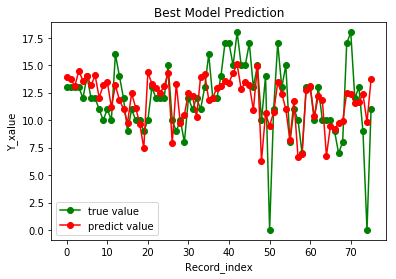

In [51]:
actual_value = [test[x, 'G3'] for x in range(len(test['G3']))]
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('Best Model Prediction', pred_value, actual_value)

#### GBM

In [52]:
# get the GBM model
model_GBM, model_GBM_ID = get_model_by_algo('GBM', bm)
model_GBM_ID

'GBM_grid_0_AutoML_20181010_191557_model_8'

In [53]:
# write scoring_history, statistic data into file
if model_GBM is not None:
    try:     
        sh_df = model_GBM.scoring_history()
        sh = os.path.join(report_Path, run_id + '_gbm_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass
    try:
        stats_gbm = gbm_stats(model_GBM)
        gbm_stats = os.path.join(report_Path, run_id + '_gbm_stats.json')
        dict_to_json(stats_gbm,gbm_stats)
        print(stats_gbm['varimp'])
    except:
        pass

[('failures', 5637.93408203125, 1.0, 0.23475355808560253), ('higher', 2865.413818359375, 0.5082382618647105, 0.119310740327983), ('school', 2117.788330078125, 0.37563197782460106, 0.08818094332505724), ('Dalc', 1278.748291015625, 0.22681150088135016, 0.05324480684663272), ('goout', 1190.7755126953125, 0.21120777493487414, 0.04958177666130484), ('studytime', 1190.095458984375, 0.21108715385256938, 0.04955346043305366), ('Walc', 892.1583862304688, 0.1582420747120618, 0.037147890077504256), ('Medu', 841.3743286132812, 0.14923450972845512, 0.035033332147915305), ('age', 746.6205444335938, 0.1324280372154687, 0.031087952926623863), ('reason', 711.3329467773438, 0.12616907832328944, 0.02961864005677326), ('absences', 703.5897827148438, 0.12479567381911506, 0.029296228462727534), ('health', 698.6141357421875, 0.12391314364046074, 0.029089051363170512), ('Fedu', 657.2098999023438, 0.11656927703304441, 0.027365052546973485), ('famrel', 630.6414794921875, 0.11185683803968462, 0.02625879072602094

In [54]:
if model_GBM is not None:
    predictions_df, mod_perf = predictions_test(model_GBM,test,run_id, False)
else:
    print('No Such Model')

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [55]:
predictions_df.head(5)

predict
13.4323
13.2623
12.8682
13.8719
13.2403


In [56]:
predictions_df.describe()

Rows:76
Cols:1




,predict
type,real
mins,7.319902390355804
mean,11.858788322719112
maxs,14.055154292958417
sigma,1.593225736197101
zeros,0
missing,0
0,13.432290880123713
1,13.26226360731884
2,12.868173543827236


In [57]:
mod_perf


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 7.20851349104132
RMSE: 2.684867499717876
MAE: 1.8760078900816584
RMSLE: 0.4249908739113054
Mean Residual Deviance: 7.20851349104132


Very similiar performance with the previous best model

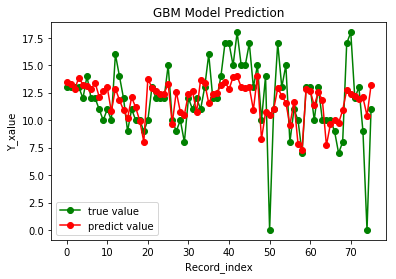

In [58]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('GBM Model Prediction', pred_value, actual_value)

#### DeepLearning

In [59]:
# get the DeepLearning model
model_DEE, model_DEE_ID = get_model_by_algo('Dee', bm)
model_DEE_ID

'DeepLearning_0_AutoML_20181010_191557'

In [60]:
# write scoring_history, statistic data, confusion_matrix into file
if model_DEE is not None:
    try:     
        sh_df = model_DEE.scoring_history()
        sh = os.path.join(report_Path, run_id + '_dl_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_dl = dl_stats(model_DEE)
        dl_stats = os.path.join(report_Path, run_id + '_dl_stats.json')
        dict_to_json(stats_dl,dl_stats)
        print(stats_dl['varimp'])
    except:
        pass
    try:
        cf = model_DEE.confusion_matrix()    
        cf_df.to_csv(os.path.join(report_Path, run_id + '_dl_confusion_matrix.csv'))
    except:
        pass

[('traveltime.1', 1.0, 1.0, 0.016236126607063944), ('health.2', 0.9968594312667847, 0.9968594312667847, 0.016185135935493273), ('Walc.4', 0.9751612544059753, 0.9751612544059753, 0.015832841588838707), ('goout.2', 0.8980069756507874, 0.8980069756507874, 0.01458015495069277), ('failures', 0.8574552536010742, 0.8574552536010742, 0.013921752057359162), ('Pstatus.T', 0.8474861979484558, 0.8474861979484558, 0.013759893207630382), ('schoolsup.yes', 0.8467555046081543, 0.8467555046081543, 0.013748029578046309), ('Fjob.health', 0.8446078896522522, 0.8446078896522522, 0.013713160629719058), ('Mjob.services', 0.8222979307174683, 0.8222979307174683, 0.013350933311855509), ('famsize.GT3', 0.8079478144645691, 0.8079478144645691, 0.013117943007547352), ('goout.1', 0.8051018118858337, 0.8051018118858337, 0.013071734949354975), ('reason.course', 0.8049784898757935, 0.8049784898757935, 0.013069732677586522), ('guardian.father', 0.799597442150116, 0.799597442150116, 0.01298236530543377), ('nursery.yes', 

In [61]:
if model_DEE is not None:
    predictions_df, mod_perf = predictions_test(model_DEE,test,run_id, False)
else:
    print('No Such Model')

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [62]:
predictions_df.head(5)

predict
14.5228
14.698
13.4193
15.1767
13.715


In [63]:
predictions_df.describe()

Rows:76
Cols:1




,predict
type,real
mins,5.040875484932056
mean,12.213926030694198
maxs,15.756755400423877
sigma,2.3824014787656718
zeros,0
missing,0
0,14.522837028849803
1,14.697974632393011
2,13.419313386555825


In [64]:
mod_perf


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 8.182538139004158
RMSE: 2.8605136145461985
MAE: 2.2064112895819408
RMSLE: 0.4265067965520003
Mean Residual Deviance: 8.182538139004158


This model preform even worse when the true value is too high/low

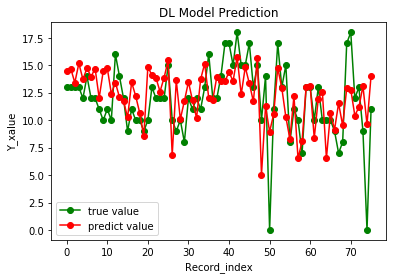

In [65]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('DL Model Prediction', pred_value, actual_value)

#### DRF

In [66]:
# get the DRF model
model_DRF, model_DRF_ID = get_model_by_algo('DRF', bm)
model_DRF_ID

'DRF_0_AutoML_20181010_191557'

In [67]:
# write scoring_history, statistic data into file
if model_DRF is not None:
    try:     
        sh_df = model_DRF.scoring_history()
        sh = os.path.join(report_Path, run_id + '_drf_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_drf = drf_stats(model_DRF)
        drf_stats = os.path.join(report_Path, run_id + '_drf_stats.json')
        dict_to_json(stats_drf,drf_stats)
        print(stats_drf['varimp'])
    except:
        pass

In [68]:
if model_DRF is not None:
    predictions_df, mod_perf = predictions_test(model_DRF,test,run_id, False)
else:
    print('No Such Model')

drf prediction progress: |████████████████████████████████████████████████| 100%


In [69]:
predictions_df.head(5)

predict
12.1111
12.5556
12.7778
13.2222
13.1111


In [70]:
predictions_df.describe()

Rows:76
Cols:1




,predict
type,real
mins,6.888888888888889
mean,11.579434697390997
maxs,15.444444444444445
sigma,2.0356466986529456
zeros,0
missing,0
0,12.11111111111111
1,12.555555555555555
2,12.777777777777779


In [71]:
mod_perf


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 8.37049671490092
RMSE: 2.893181071917366
MAE: 2.1145224166892427
RMSLE: 0.42962175850702045
Mean Residual Deviance: 8.37049671490092


This model have good Mean Residual Deviance, similiar performance with the others

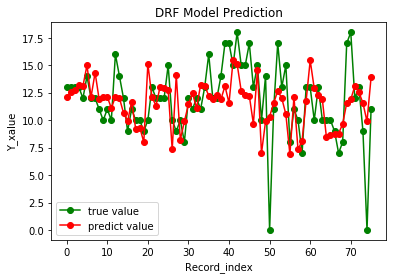

In [72]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('DRF Model Prediction', pred_value, actual_value)

#### XRT

In [73]:
# get the XRT model
model_XRT, model_XRT_ID = get_model_by_algo('XRT', bm)
model_XRT_ID

'XRT_0_AutoML_20181010_191557'

In [74]:
# write scoring_history, statistic data into file
if model_XRT is not None:
    try:     
        sh_df = model_XRT.scoring_history()
        sh = os.path.join(report_Path, run_id + '_xrt_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_xrt = xrt_stats(model_XRT)
        xrt_stats = os.path.join(report_Path, run_id + '_xrt_stats.json')
        dict_to_json(stats_xrt,xrt_stats)
        print(stats_xrt['varimp'])
    except:
        pass

In [75]:
if model_XRT is not None:
    predictions_df, mod_perf = predictions_test(model_XRT,test,run_id, False)
else:
    print('No Such Model')

drf prediction progress: |████████████████████████████████████████████████| 100%


In [76]:
predictions_df.head(5)

predict
14.2727
12.3636
12.7727
13.8182
14


In [77]:
predictions_df.describe()

Rows:76
Cols:1




,predict
type,real
mins,6.863636363636363
mean,11.53915470524838
maxs,14.909090909090908
sigma,1.900311076803083
zeros,0
missing,0
0,14.272727272727273
1,12.363636363636363
2,12.772727272727273


In [78]:
mod_perf


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 7.124928586446012
RMSE: 2.6692561859900246
MAE: 1.8555821368568821
RMSLE: 0.41819454483038604
Mean Residual Deviance: 7.124928586446012


All the measurement index are similiar

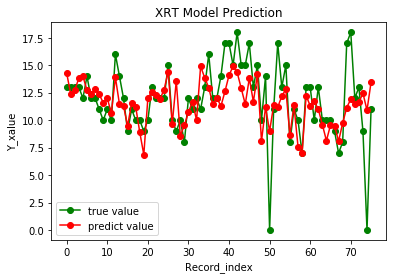

In [79]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('XRT Model Prediction', pred_value, actual_value)

#### GLM

In [80]:
# get the XRT model
model_GLM, model_GLM_ID = get_model_by_algo('GLM', bm)
model_GLM_ID

'GLM_grid_0_AutoML_20181010_191557_model_0'

In [81]:
# write scoring_history, statistic data into file
if model_GLM is not None:
    try:     
        sh_df = model_GLM.scoring_history()
        sh = os.path.join(report_Path, run_id + '_glm_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_glm = glm_stats(model_GLM)
        glm_stats = os.path.join(report_Path, run_id + '_glm_stats.json')
        dict_to_json(stats_glm,glm_stats)
        print(stats_glm['varimp'])
    except:
        pass

In [82]:
if model_GLM is not None:
    predictions_df, mod_perf = predictions_test(model_GLM,test,run_id, False)
else:
    print('No Such Model')

glm prediction progress: |████████████████████████████████████████████████| 100%


In [83]:
predictions_df.head(5)

predict
13.7778
13.3285
12.8698
14.8767
12.9761


In [84]:
predictions_df.describe()

Rows:76
Cols:1




,predict
type,real
mins,6.58606995023685
mean,11.919430766805073
maxs,14.876650120324218
sigma,1.8888430167844636
zeros,0
missing,0
0,13.777796042310133
1,13.328476969334877
2,12.869778506010313


In [85]:
mod_perf


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 7.58072163776321
RMSE: 2.7533110317875837
MAE: 1.9893665439403267
RMSLE: 0.4296577229764585
R^2: 0.2799261909663152
Mean Residual Deviance: 7.58072163776321
Null degrees of freedom: 75
Residual degrees of freedom: -19
Null deviance: 800.1942980801143
Residual deviance: 576.1348444700039
AIC: 561.6248952946474


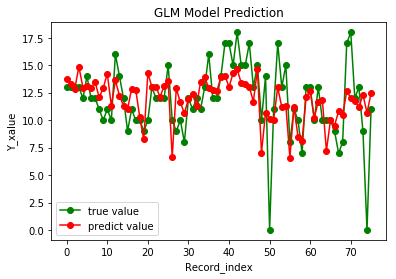

In [86]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('GLM Model Prediction', pred_value, actual_value)

### 8. Clean up

#### Update and save meta data

In [87]:
meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
meta_data_path = os.path.join(run_dir, run_id + '_meta_data.json')
dict_to_json(meta_data, meta_data_path)

#### shutdown

In [88]:
os.chdir(rootDir)
h2o.cluster().shutdown()

H2O session _sid_b8c5 closed.
